# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

     |████████████████████████████████| 519.5MB 29kB/s 
ERROR: fastai 1.0.52 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 16.0MB 4.4MB/s 
     |████████████████████████████████| 5.4MB 4.8MB/s 


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from train import *
from model import *

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

device = torch.device("cuda:0")

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'PRON', 'NOUN', 'PRT', 'ADP', '.', 'VERB', 'X', 'ADJ', 'DET', 'ADV', 'NUM', 'CONJ'}


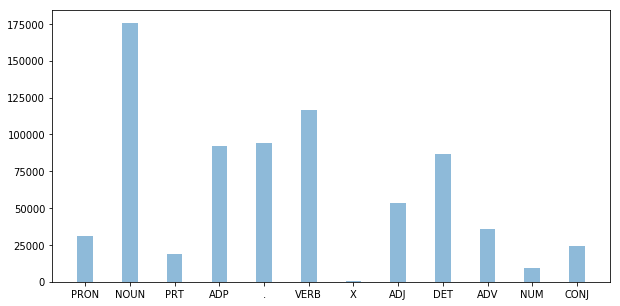

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 93.43%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [14]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape #это норма!

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [34]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

preds = torch.argmax(logits, dim=-1)

mask = (y_batch != 0).float()
correct_count = ((preds == y_batch).float() * mask).sum().item()
total_count = mask.sum().item()

correct_count / total_count

0.07608695652173914

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion(logits.reshape(logits.shape[0]*logits.shape[1], len(tag2ind)),
          y_batch.reshape(y_batch.shape[0]*y_batch.shape[1]))

tensor(2.5616, grad_fn=<NllLossBackward>)

**Задание** Вставьте эти вычисление в функцию:

In [67]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.67884, Accuracy = 78.59%: 100%|██████████| 572/572 [00:06<00:00, 85.24it/s]
[1 / 10]   Val: Loss = 0.35092, Accuracy = 88.22%: 100%|██████████| 13/13 [00:00<00:00, 72.75it/s]
[2 / 10] Train: Loss = 0.27239, Accuracy = 90.99%: 100%|██████████| 572/572 [00:06<00:00, 88.11it/s]
[2 / 10]   Val: Loss = 0.22922, Accuracy = 92.32%: 100%|██████████| 13/13 [00:00<00:00, 77.56it/s]
[3 / 10] Train: Loss = 0.18427, Accuracy = 93.89%: 100%|██████████| 572/572 [00:06<00:00, 88.06it/s]
[3 / 10]   Val: Loss = 0.18292, Accuracy = 93.85%: 100%|██████████| 13/13 [00:00<00:00, 75.84it/s]
[4 / 10] Train: Loss = 0.13801, Accuracy = 95.39%: 100%|██████████| 572/572 [00:06<00:00, 90.16it/s]
[4 / 10]   Val: Loss = 0.15880, Accuracy = 94.61%: 100%|██████████| 13/13 [00:00<00:00, 77.06it/s]
[5 / 10] Train: Loss = 0.10759, Accuracy = 96.37%: 100%|██████████| 572/572 [00:06<00:00, 89.62it/s]
[5 / 10]   Val: Loss = 0.14707, Accuracy = 94.92%: 100%|██████████| 13/13 [00:00<00:00, 78.04it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [0]:
def test_model(model, data):
    X_test, y_test = data
    correct_count = 0
    sum_count = 0
    model.eval()
    for i, (X_batch, y_batch) in enumerate(iterate_batches((X_test, y_test), 512)):
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=-1)
        mask = (y_batch != 0).float()
        cur_correct_count, cur_sum_count = ((preds == y_batch).float() * mask).sum().item(), mask.sum().item()
        correct_count += cur_correct_count
        sum_count += cur_sum_count
    return correct_count / sum_count

In [69]:
test_model(model, (X_test, y_test))

0.9517814293435788

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [70]:
model = BiLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.62909, Accuracy = 80.89%: 100%|██████████| 572/572 [00:09<00:00, 58.80it/s]
[1 / 10]   Val: Loss = 0.29418, Accuracy = 90.50%: 100%|██████████| 13/13 [00:00<00:00, 56.46it/s]
[2 / 10] Train: Loss = 0.21950, Accuracy = 93.10%: 100%|██████████| 572/572 [00:09<00:00, 66.16it/s]
[2 / 10]   Val: Loss = 0.19079, Accuracy = 93.92%: 100%|██████████| 13/13 [00:00<00:00, 56.02it/s]
[3 / 10] Train: Loss = 0.14105, Accuracy = 95.66%: 100%|██████████| 572/572 [00:08<00:00, 66.23it/s]
[3 / 10]   Val: Loss = 0.15017, Accuracy = 95.20%: 100%|██████████| 13/13 [00:00<00:00, 63.84it/s]
[4 / 10] Train: Loss = 0.09924, Accuracy = 97.00%: 100%|██████████| 572/572 [00:08<00:00, 66.26it/s]
[4 / 10]   Val: Loss = 0.12830, Accuracy = 95.88%: 100%|██████████| 13/13 [00:00<00:00, 60.20it/s]
[5 / 10] Train: Loss = 0.07235, Accuracy = 97.82%: 100%|██████████| 572/572 [00:08<00:00, 66.20it/s]
[5 / 10]   Val: Loss = 0.11964, Accuracy = 96.10%: 100%|██████████| 13/13 [00:00<00:00, 58.60it/s]


In [71]:
#!!!   overfit, because embedding weights change   !!!
test_model(model, (X_test, y_test))

0.9647191266537909

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [30]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [72]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
embeddings = torch.Tensor(embeddings)
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [84]:
model = BiLSTMTagger(
    vocab_size=embeddings.shape[0],
    tagset_size=len(tag2ind),
    word_emb_dim=embeddings.shape[1],
    embeddings=embeddings,
    freeze=False
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.40298, Accuracy = 88.76%: 100%|██████████| 572/572 [00:08<00:00, 69.81it/s]
[1 / 10]   Val: Loss = 0.11479, Accuracy = 96.47%: 100%|██████████| 13/13 [00:00<00:00, 59.70it/s]
[2 / 10] Train: Loss = 0.07167, Accuracy = 97.79%: 100%|██████████| 572/572 [00:08<00:00, 66.59it/s]
[2 / 10]   Val: Loss = 0.08606, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 60.46it/s]
[3 / 10] Train: Loss = 0.04568, Accuracy = 98.55%: 100%|██████████| 572/572 [00:08<00:00, 66.33it/s]
[3 / 10]   Val: Loss = 0.08623, Accuracy = 97.20%: 100%|██████████| 13/13 [00:00<00:00, 58.10it/s]
[4 / 10] Train: Loss = 0.03329, Accuracy = 98.94%: 100%|██████████| 572/572 [00:09<00:00, 60.24it/s]
[4 / 10]   Val: Loss = 0.09034, Accuracy = 97.06%: 100%|██████████| 13/13 [00:00<00:00, 58.53it/s]
[5 / 10] Train: Loss = 0.02573, Accuracy = 99.17%: 100%|██████████| 572/572 [00:08<00:00, 61.01it/s]
[5 / 10]   Val: Loss = 0.09309, Accuracy = 96.93%: 100%|██████████| 13/13 [00:00<00:00, 54.26it/s]


In [85]:
#freeze=True: 98.11% 96.93% 96.99%

#!!!   overfit, because embedding weights change   !!!
test_model(model, (X_test, y_test))

0.9675008348567317

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [0]:
words_val = {word for sample in val_data for word, tag in sample}
words_test = {word for sample in test_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words | words_val | words_test)}
word2ind['<pad>'] = 0

In [0]:
X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [100]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
embeddings = torch.Tensor(embeddings)
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 46506 out of 56058 word embeddings


In [101]:
model = BiLSTMTagger(
    vocab_size=embeddings.shape[0],
    tagset_size=len(tag2ind),
    word_emb_dim=embeddings.shape[1],
    embeddings=embeddings
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.56788, Accuracy = 83.78%: 100%|██████████| 572/572 [00:07<00:00, 78.52it/s]
[1 / 10]   Val: Loss = 0.24526, Accuracy = 92.69%: 100%|██████████| 13/13 [00:00<00:00, 62.84it/s]
[2 / 10] Train: Loss = 0.19085, Accuracy = 94.40%: 100%|██████████| 572/572 [00:07<00:00, 80.95it/s]
[2 / 10]   Val: Loss = 0.16109, Accuracy = 95.26%: 100%|██████████| 13/13 [00:00<00:00, 64.12it/s]
[3 / 10] Train: Loss = 0.13559, Accuracy = 95.95%: 100%|██████████| 572/572 [00:08<00:00, 69.19it/s]
[3 / 10]   Val: Loss = 0.12686, Accuracy = 96.13%: 100%|██████████| 13/13 [00:00<00:00, 55.32it/s]
[4 / 10] Train: Loss = 0.10917, Accuracy = 96.70%: 100%|██████████| 572/572 [00:07<00:00, 77.47it/s]
[4 / 10]   Val: Loss = 0.10862, Accuracy = 96.66%: 100%|██████████| 13/13 [00:00<00:00, 59.21it/s]
[5 / 10] Train: Loss = 0.09367, Accuracy = 97.15%: 100%|██████████| 572/572 [00:06<00:00, 82.19it/s]
[5 / 10]   Val: Loss = 0.09918, Accuracy = 96.94%: 100%|██████████| 13/13 [00:00<00:00, 61.62it/s]


In [102]:
test_model(model, (X_test, y_test))

0.9748888865937501